In [1]:
import matplotlib.pyplot as plt
% matplotlib notebook

In [2]:
# Team Dapper Strategy tank model for SACAC Hackathon 2018
# Assuming linear level and valve responses

TANK_VOLUME = 10.0       # m³
LEVEL = 0.5             # initial tank level fraction
LMIN = 0.05             # minimum level setting
LMAX = 0.95             # maximum level setting
LEAK_CONST = 0.0        # leakrate = leakconst*level
TOTAL_OVERFLOW = 0.0    # historical waste total
TOTAL_SHORTFAL = 0.0    # historical total water shortfall
TOTAL_CONSUMP = 0.0     # historical total consumption of sources
SHORTFALL = False       # did the tank experience a water shortfall in the last step
OVERFLOW = False        # did the tank overflow in the last step

def stepTank(MW=0, MWMax=1, BW=0, BWMax=1, RW=0, HU=0, GU=0, updateLevel=True):
    """Perform one timestep of tank simulation and return new level.
    Other parameters will be stored in global module vars.
    Keyword arguments:
    MW -- municipal water valve setting         (fraction)
    MWMax -- municipal water max supply         (m³/h)
    BW -- borehole water valve setting          (fraction)
    BWMax -- borehole water current max supply  (m³/h)
    RW -- rainwater flow into tank              (m³/h)
    HU -- home usage                            (m³/h)
    updateLevel -- update global level var      (bool)
    """
    global LEVEL, TOTAL_CONSUMP, TOTAL_OVERFLOW, TOTAL_SHORTFAL,\
           SHORTFALL, OVERFLOW

    consumption = HU + GU
    TOTAL_CONSUMP += consumption
    accumulation = (MW*MWMax + BW*BWMax + RW) -\
                   (consumption + LEVEL*LEAK_CONST)
    newVolume = TANK_VOLUME*LEVEL + accumulation

    if newVolume > TANK_VOLUME*LMAX:
        TOTAL_OVERFLOW += newVolume - TANK_VOLUME*LMAX
        SHORTFALL = False
        OVERFLOW = True
        newLevel = LMAX
    elif newVolume < TANK_VOLUME*LMIN:
        TOTAL_SHORTFAL += TANK_VOLUME*LMIN - newVolume
        SHORTFALL = True
        OVERFLOW = False
        newLevel = LMIN
    else:
        SHORTFALL = False
        OVERFLOW = False
        newLevel = newVolume/TANK_VOLUME

    if updateLevel:
        LEVEL=newLevel

    return newLevel

def simTank(MW=[1], BW=[1], HU=[1], GU=[1], RW=[1], LInit=0.5):
    """Calculate total waste and underflow volumes for specified data
    Keyword arguments:
    MW --  municipal water usage     (array m³/h)
    BW --  borehole water usage      (array m³/h)
    HU --  home water usage          (array m³/h)
    GU --  garden water usage        (array m³/h)
    RW --  rainwater                 (array m³/h)
    LInit -- initial tank level      (fraction)
    """

    totOverflow = 0
    totUnderflow = 0
    totConsumption = 0

    for i in range(0, len(MW)):
        totConsumption += MW[i] + BW[i]

        if not i:
            currLevel = LInit

        accumulation = (MW[i] + BW[i] + RW[i]) - (HU[i] + GU[i] + currLevel*LEAK_CONST)
        newVolume = TANK_VOLUME*currLevel + accumulation

        if newVolume > TANK_VOLUME*LMAX:
            currLevel = LMAX
            totOverflow += newVolume - TANK_VOLUME*LMAX
        elif newVolume < TANK_VOLUME*LMIN:
            currLevel = LMIN
            totUnderflow += TANK_VOLUME*LMIN - newVolume
        else:
            currLevel = newVolume/TANK_VOLUME

    return totOverflow, totUnderflow, totConsumption, currLevel

In [14]:
print('HU in m3/h: ', maximum_municipal_water)

HU in m3/h:  0.45


In [5]:
# Guestimate max available water
maximum_municipal_water = 5 * 750/30 * 3600 / 1000 / 1000

# Controller
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Variable limits
limits = {
    'MW': [0, maximum_municipal_water],
    'BW': [0, 0.2 * maximum_municipal_water],
    'RW': [0, 0.1 * maximum_municipal_water],
    'HU': [0, 0.8 * maximum_municipal_water],
    'GU': [0, 0.5 * maximum_municipal_water]
}

# New Antecedent/Consequent objects hold universe variables and membership
# functions
f_tank_level = ctrl.Antecedent(np.arange(0, 1, 0.01), 'level')
f_tank_error = ctrl.Antecedent(np.arange(-0.2, 0.2, 0.01), 'level_error')
f_tank_error_sum = ctrl.Antecedent(np.arange(-0.05, 0.05, 0.001), 'level_error_sum')

f_rain_water = ctrl.Antecedent(np.arange(0, limits['RW'][1], 0.001), 'rain_water')
f_house_usage = ctrl.Antecedent(np.arange(0, limits['HU'][1], 0.001), 'house_usage')
f_garden_usage = ctrl.Antecedent(np.arange(0, limits['GU'][1], 0.001), 'garden_usage')

f_municipal_water = ctrl.Consequent(np.arange(0, limits['MW'][1], 0.001), 'municipal_water')
f_bore_hole_water = ctrl.Consequent(np.arange(0, limits['BW'][1], 0.001), 'bore_hole_water')

# Auto-membership function population is possible with .automf(3, 5, or 7)
f_tank_level.automf(3)
f_tank_error.automf(3)
f_tank_error_sum.automf(3)

f_rain_water.automf(3)
f_house_usage.automf(3)
f_garden_usage.automf(3)
f_municipal_water.automf(3)
f_bore_hole_water.automf(3)

# Special function to ensure better(?) action
max_mw = maximum_municipal_water
f_municipal_water['poor'] = fuzz.gaussmf(f_municipal_water.universe, 0, max_mw/500)
f_municipal_water['average'] = fuzz.gaussmf(f_municipal_water.universe, max_mw/2, max_mw/8)
f_municipal_water['good'] = fuzz.gaussmf(f_municipal_water.universe, max_mw, max_mw/5)

f_tank_error['poor'] = fuzz.gaussmf(f_tank_error.universe, -0.2, 0.02)
f_tank_error['average'] = fuzz.gaussmf(f_tank_error.universe, 0, 0.05)
f_tank_error['good'] = fuzz.gaussmf(f_tank_error.universe, 0.15, 0.005)
f_tank_error['very_high'] = fuzz.gaussmf(f_tank_error.universe, 0.2, 0.02)

f_tank_error_sum['poor'] = fuzz.gaussmf(f_tank_error_sum.universe, -0.05, 0.01)
f_tank_error_sum['average'] = fuzz.gaussmf(f_tank_error_sum.universe, 0, 0.02)
f_tank_error_sum['good'] = fuzz.gaussmf(f_tank_error_sum.universe, 0.05, 0.01)

C:\Users\attie\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


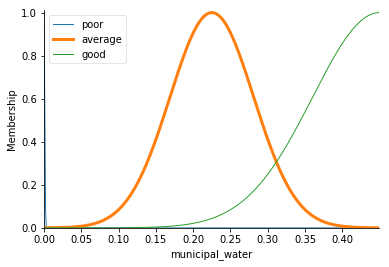

In [6]:
f_municipal_water['average'].view()

In [7]:
# just for ease of use:
neg_error = 'poor'
pos_error = 'good'
small_error = 'average'

lo = 'poor'
med = 'average'
hi = 'good'

# probable need input weighting based on available resource
rule_highest_error = ctrl.Rule(f_tank_error['very_high'], f_municipal_water[hi])
rule_high_error = ctrl.Rule(f_tank_error[pos_error], f_municipal_water[med])
rule_low_error = ctrl.Rule(f_tank_error[neg_error], f_municipal_water[lo])
rule_slight_error = ctrl.Rule(f_tank_error[small_error], f_municipal_water[lo])

rule_for_integral_error_pos = ctrl.Rule(f_tank_error_sum[pos_error], f_municipal_water[hi])
rule_for_integral_error_neg = ctrl.Rule(f_tank_error_sum[neg_error], f_municipal_water[lo])
rule_for_integral_error_small = ctrl.Rule(f_tank_error_sum[small_error], f_municipal_water[lo])

0.291841893588462


C:\Users\attie\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


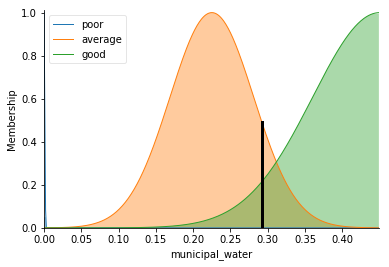

In [10]:
# Create controller
base_ctrl = ctrl.ControlSystem([
    rule_high_error, 
    rule_low_error, 
    rule_slight_error, 
    rule_for_integral_error_pos,
    rule_for_integral_error_neg,
    rule_for_integral_error_small,
    rule_highest_error
])
base = ctrl.ControlSystemSimulation(base_ctrl)

base.input['level_error'] =  0.15
base.input['level_error_sum'] =  0.1

# Crunch the numbers
base.compute()
f_municipal_water.view(sim=base)

print(base.output['municipal_water'])


In [11]:
def random_walk(v, max_):
    step = max_/2
    v = v + np.random.random() * step/2 * np.random.randint(-1, 2)
    v = v if v < max_ else max_
    v = v if v > 0 else 0
    return v

level = 0.5
levels = []
mws = []
gus = []
hus = []
rws = []
sums = []
sum_error = 0
bws = []

gu, hu, rw = 0, 0, 0

hours = 24 * 31
np.random.seed(1337)

for i in range(hours):
    level_error = 0.5 - level
    base.input['level_error'] = level_error
    sum_error += level_error
    sum_error = -0.05 if sum_error < - 0.05 else sum_error
    sum_error = 0.05 if sum_error > 0.05 else sum_error
    sums.append(sum_error)
    base.input['level_error_sum'] = sum_error
    base.compute()
    mw = base.output['municipal_water']
    
    hu = random_walk(hu, limits['HU'][1])
    gu = random_walk(gu, limits['GU'][1])
    rw = random_walk(rw, limits['RW'][1])
    
    hus.append(hu)
    gus.append(gu)
    rws.append(rw)
    mws.append(mw)
    
    overflow, nolevel, consumption, level = simTank(MW=[mw], BW=[0], HU=[hu], GU=[gu], RW=[rw], LInit=level)
    levels.append(level)


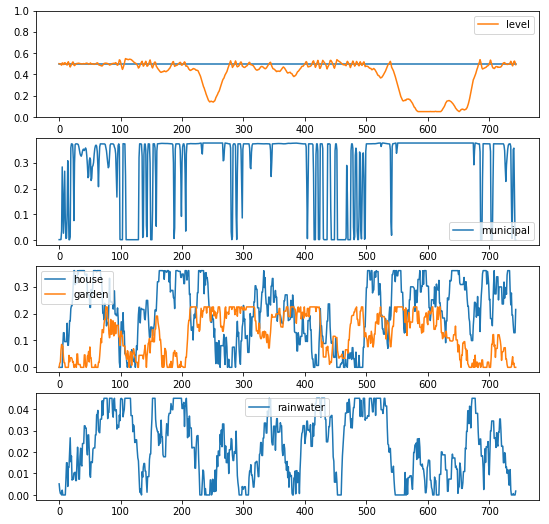

In [12]:
fig, axx = plt.subplots(4, 1, figsize=(9, 9))

axx[0].plot(np.arange(0, len(hus), 1), [0.5] * len(hus))
axx[0].plot(np.arange(0, len(hus), 1), levels, label='level')
axx[0].set_ylim([0, 1])

axx[1].plot(np.arange(0, len(mws), 1), mws, label='municipal')

axx[2].plot(np.arange(0, len(hus), 1), hus, label='house')
axx[2].plot(np.arange(0, len(gus), 1), gus, label='garden')

axx[3].plot(np.arange(0, len(rws), 1), rws, label='rainwater')
# axx[0].plot(np.arange(0, len(hus), 1), bws, label='bws')
# axx[1].set_ylim([0, 1])

for ax in axx:
    ax.legend()